In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb 
import os
from datetime import timedelta

In [4]:
xsl = pd.ExcelFile('/Users/ta.duong/Code/projects/python/KPMG-project/data/KPMG_data_work.xlsx')
cd_df = pd.read_excel(xsl, sheet_name= "CustomerDemographic")
ncl_df = pd.read_excel(xsl, sheet_name= "NewCustomerList")
t_df = pd.read_excel(xsl, sheet_name= "Transactions")
ca_df = pd.read_excel(xsl, sheet_name= "CustomerAddress")

In [5]:
rfm = t_df.groupby("customer_id").agg(
    recency=("recency", "min"),
    frequency=("transaction_id", "count"),
    monetary=("Profit($)","sum")
)
rfm.head()

,recency,frequency,monetary
customer_id,,,
1,7,11,3018.09
2,128,3,2226.26
3,102,7,3290.21
4,195,2,220.57
5,16,6,2394.94


In [6]:
# --Calculate R, F, and M groups--
rfm['r_percentile'] = rfm['recency'].rank(pct=True,ascending=True)
rfm['f_percentile'] = rfm['frequency'].rank(pct=True,ascending=False)
rfm['m_percentile'] = rfm['monetary'].rank(pct=True,ascending=False)
rfm['r_score'] = pd.qcut(rfm['r_percentile'], 5, labels=range(5,0,-1))
rfm['f_score'] = pd.qcut(rfm['f_percentile'], 5, labels=range(5,0,-1))
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 5, labels=range(5,0,-1))
# Concat RFM quartile values to create RFM Segments
rfm['rfm_segment_concat'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str) 
# Calculate RFM_Score
rfm['rfm_score'] = rfm[['r_score','f_score','m_score']].sum(axis=1) 
rfm['rfm_score'] = rfm['rfm_score'].astype(int)


In [7]:
# Define rfm_level function 
def rfm_level(df):
    if (((df['r_score'] >= 5) and (df['r_score'] < 6)) and ((df['f_score'] >= 4) and (df['f_score'] < 6))):
        return 'champions'
    elif (((df['r_score'] >= 4) and (df['r_score'] < 6)) and ((df['f_score'] >= 2) and (df['f_score'] < 4))):
        return 'potential loyalists'
    elif (((df['r_score'] >= 5) and (df['r_score'] < 6)) and ((df['f_score'] >= 1) and (df['f_score'] < 2))):
        return 'new customers'
    elif (((df['r_score'] >= 4) and (df['r_score'] < 5)) and ((df['f_score'] >= 1) and (df['f_score'] < 2))):
        return 'promising'
    elif (((df['r_score'] >= 3) and (df['r_score'] < 5)) and ((df['f_score'] >= 4) and (df['f_score'] < 6))):
        return 'loyal customers'
    elif (((df['r_score'] >= 3) and (df['r_score'] < 4)) and ((df['f_score'] >= 3) and (df['f_score'] < 4))):
        return 'need attention'
    elif (((df['r_score'] >= 3) and (df['r_score'] < 4)) and ((df['f_score'] >= 1) and (df['f_score'] < 3))):
        return 'about to sleep'
    elif (((df['r_score'] >= 1) and (df['r_score'] < 3)) and ((df['f_score'] >= 5) and (df['f_score'] < 6))):
        return 'can\'t loose'
    elif (((df['r_score'] >= 1) and (df['r_score'] < 3)) and ((df['f_score'] >= 3) and (df['f_score'] < 5))):
        return 'at risk'
    elif (((df['r_score'] >= 1) and (df['r_score'] < 3)) and ((df['f_score'] >= 1) and (df['f_score'] < 3))):
        return 'hibernating'
    else:
        return 'not categorize'
# Create a new variable RFM_Level
rfm['rfm_level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,recency,frequency,monetary,r_percentile,f_percentile,m_percentile,r_score,f_score,m_score,rfm_segment_concat,rfm_score,rfm_level
customer_id,,,,,,,,,,,,
1,7,11,3018.09,0.103009,0.017479,0.449284,5,5,3,553,13,champions
2,128,3,2226.26,0.862178,0.862751,0.642980,1,1,2,112,4,hibernating
3,102,7,3290.21,0.799140,0.248854,0.396275,2,5,4,254,11,can't loose
4,195,2,220.57,0.958023,0.951862,0.983095,1,1,1,111,3,hibernating
5,16,6,2394.94,0.226934,0.393266,0.601146,4,4,2,442,10,loyal customers


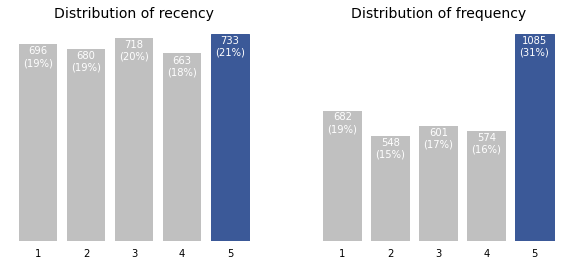

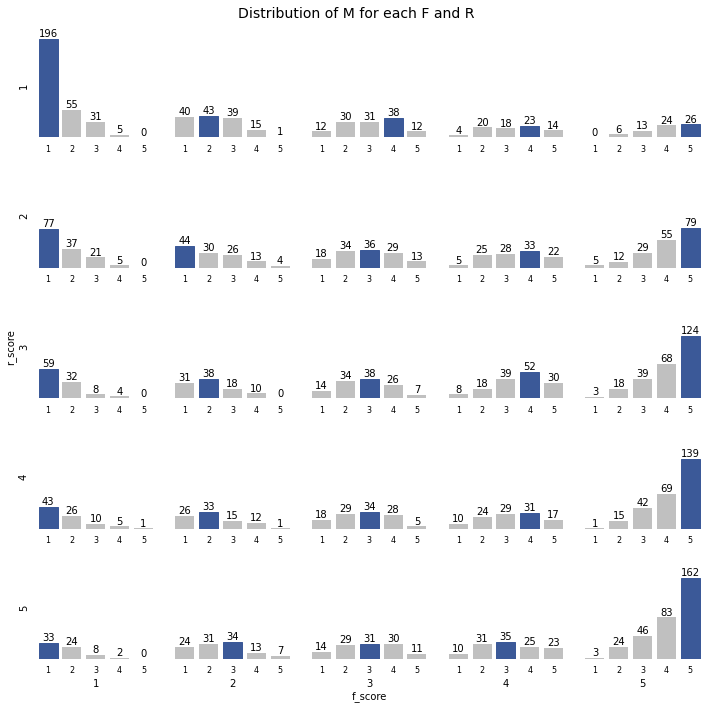

In [51]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['r_score', 'f_score']):
    parameters = {'r_score':'recency', 'f_score':'frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('#3b5998')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['r_score'] == r) & (rfm['f_score'] == f)]['m_score'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nf_score'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('r_score\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('#3b5998')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

### We can see that recency seems evenly distributed, almost half of the customers purchase very often (47% of customers have a frequency of 4 or 5).
### When looking at the monetary value, we see that the customers spending the most are those with the highest activity (R and F of 4-5). We have very few large orders (high monetary value but low frequency).

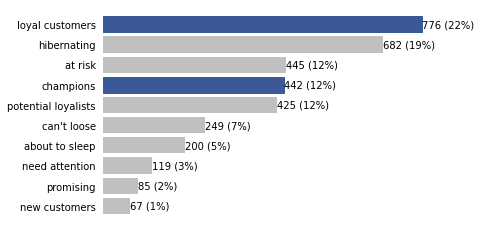

In [9]:
# count the number of customers in each segment
segments_counts = rfm['rfm_level'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,7)
bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('#3b5998')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
plt.show()

### We can see that almost 1/5 of our customers who used to buy from us but no longer are buying (19% Hibernating).
### However, we have 32% of customers who are either loyal or champion customers. 

## Next, we will try to find the traints of the loyal and chamption customers.

In [10]:
# Data preparation
rfm_df = rfm.filter(['customer_id','monetary', 'rfm_level'], axis=1)
# Grab only necessary data from  t_df
new_t_df = t_df.filter(['customer_id', 'online_order', 'brand',	'product_line',	'product_class','product_size'], axis = 1)

# https://stackoverflow.com/questions/44165629/pandas-pivot-table-for-multiple-columns-at-once
# Transform new_t_df to count needed column
new_t_df =(new_t_df.set_index('customer_id').stack() 
 .groupby(level=[0,1])
 .value_counts()
 .unstack(level=[1,2])
 .fillna(0)
 .sort_index(axis=1))


#https://stackoverflow.com/questions/24290297/pandas-dataframe-with-multiindex-column-merge-levels
# Merge levels of multilevel indexes
new_t_df.columns = new_t_df.columns.map('{0[0]}|{0[1]}'.format) 

# Merging to get all of the data we need in a single table
cdrfm_df = pd.merge(pd.merge(pd.merge(cd_df, ca_df, on='customer_id'), rfm_df, on='customer_id'), new_t_df, on='customer_id').set_index('customer_id')
# Dropping excess data
drop = ['first_name', 'last_name', 'DOB', 'Age', 'job_title', 'deceased_indicator', 'tenure', 'address' , 'postcode', 'postcode',  'country', 'property_valuation']
cdrfm_df.drop(columns = drop, inplace = True)

In [11]:
cdrfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2992 entries, 1 to 3497
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               2992 non-null   object 
 1   past_3_years_bike_related_purchases  2992 non-null   int64  
 2   Age_group                            2992 non-null   object 
 3   job_industry_category                2519 non-null   object 
 4   wealth_segment                       2992 non-null   object 
 5   owns_car                             2992 non-null   object 
 6   state                                2992 non-null   object 
 7   monetary                             2992 non-null   float64
 8   rfm_level                            2992 non-null   object 
 9   brand|Giant Bicycles                 2992 non-null   float64
 10  brand|Norco Bicycles                 2992 non-null   float64
 11  brand|OHM Cycles              

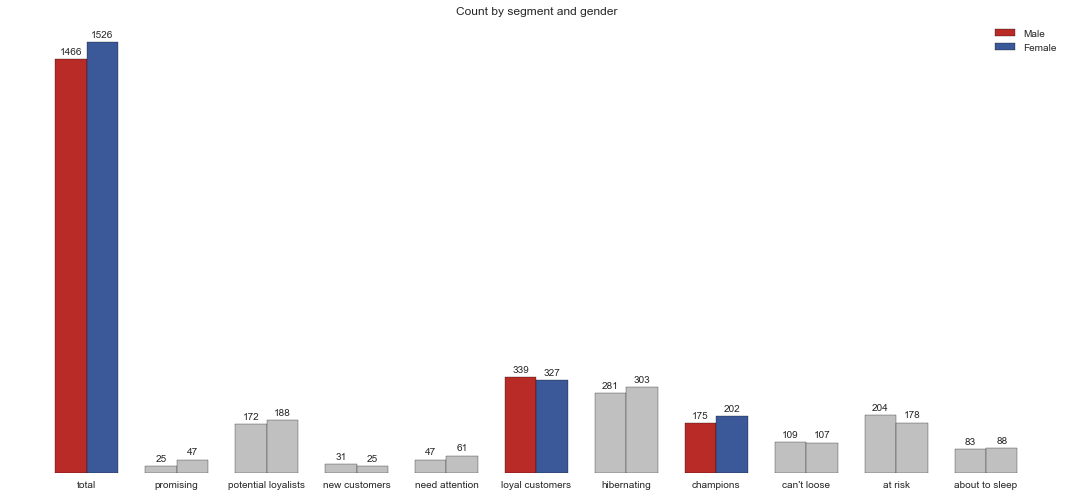

In [535]:
gender_df = cdrfm_df.groupby(['rfm_level', 'gender'])['gender'].count().unstack().fillna(0)
gender_df.loc["total"] = gender_df.sum()
gender_df.sort_index(axis=0,ascending=False, inplace = True)
def gender():
    labels = gender_df.index
    male= gender_df['Male']
    female= gender_df['Female']
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize = (15,7))
    rects1 = ax.bar(x - width/2, male, width, label='Male', edgecolor='k',
    color = ['#b92b27','silver', 'silver', 'silver', 'silver', '#b92b27', 'silver', '#b92b27', 'silver','silver', 'silver', 'silver'])
    rects2 = ax.bar(x + width/2, female, width, label='Female', edgecolor='k',
    color = ['#3b5998','silver', 'silver', 'silver', 'silver', '#3b5998', 'silver', '#3b5998', 'silver', 'silver', 'silver', 'silver'])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title('Count by segment and gender')
    ax.set_xticks(x)
    ax.tick_params(axis='x', rotation = 0)
    ax.tick_params(left=False, labelleft=False, bottom = False)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_frame_on(False)
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    fig.tight_layout()

    plt.show()
gender()

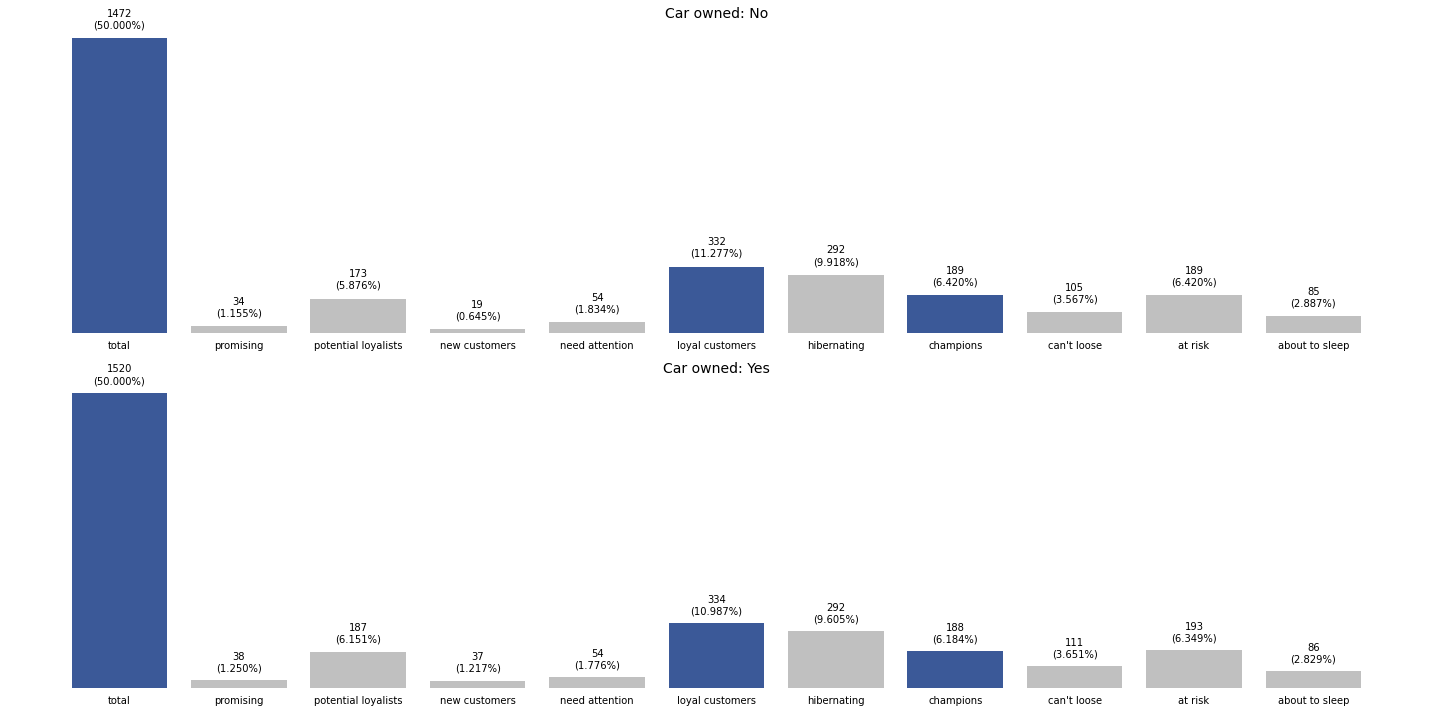

In [423]:
# Data preparation
car_df = cdrfm_df.groupby(['rfm_level', 'owns_car'])['owns_car'].count().unstack().fillna(0)
car_df.loc["total"] = car_df.sum()
car_df.sort_index(axis=0,ascending=False, inplace = True)
# plot the distribution of customers over R and F

def car():
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

    for i, p in enumerate(car_df.columns):
        parameters = car_df.columns
        y = car_df[p]
        x = y.index
        ax = axes[i]
        colors = ['#3b5998','silver', 'silver', 'silver', 'silver', '#3b5998', 'silver', '#3b5998', 'silver', 'silver', 'silver', 'silver']
        bars = ax.bar(x, y, color= colors)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelrotation=0)
        ax.set_title('Car owned: {}'.format(p),
                    fontsize=14)
        for bar in bars:
            value = bar.get_height()
            if value == y.any():
                bar.set_color("k")
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value + 150,
                    '{}\n({:.3f}%)'.format(int(value), float(value * 100 / y.sum())),
                ha='center',
                va='top',
                color='k')
    
    fig.tight_layout()
    plt.show()
car()

In [521]:
order_df

,Online_order,Offline_order
rfm_level,,
total,8245,8305
promising,109,84
potential loyalists,818,818
new customers,71,78
need attention,252,288
loyal customers,2505,2500
hibernating,861,901
champions,1488,1443
can't loose,850,845


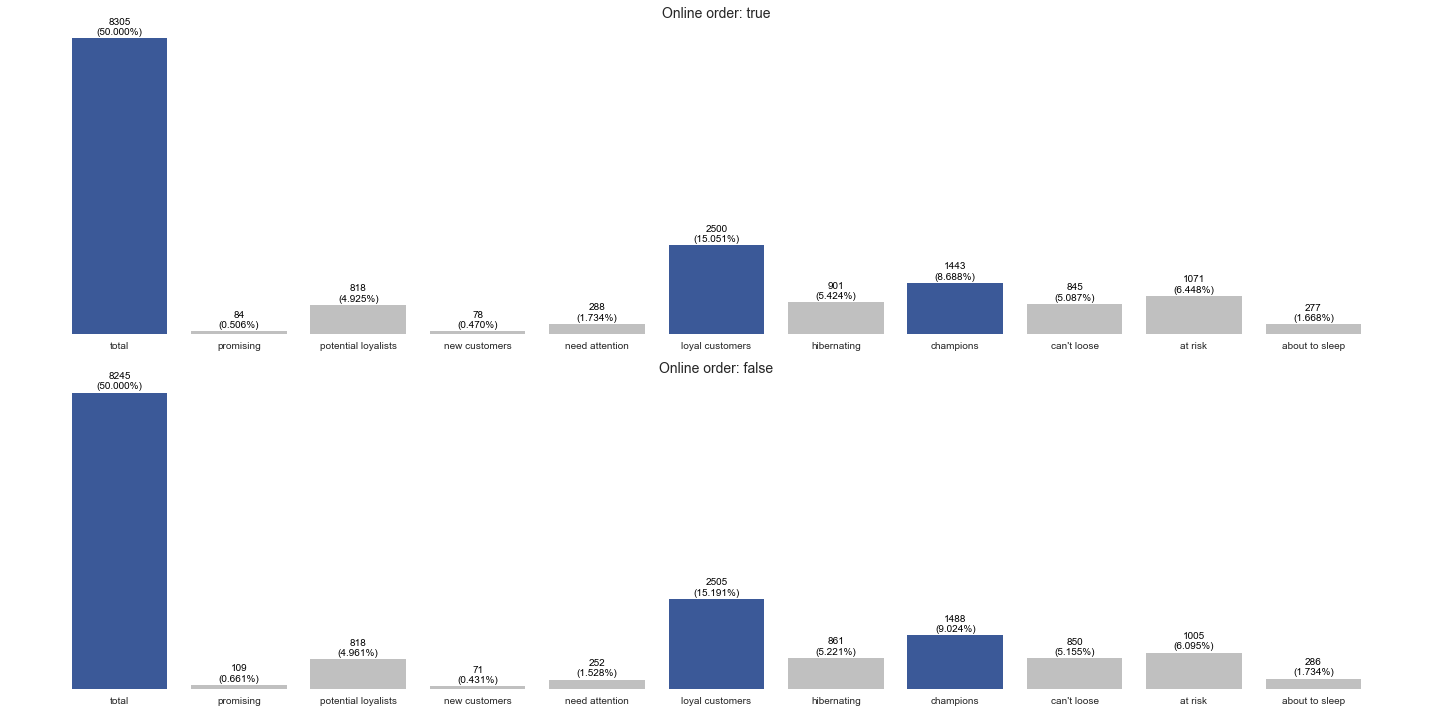

In [548]:
# Data preparation
order_df = cdrfm_df.groupby('rfm_level').agg(
    true = ('online_order|True', 'sum'),
    false = ('online_order|False','sum')
).astype(int)
order_df.loc["total"] = order_df.sum()
order_df.sort_index(axis=0,ascending=False, inplace = True)

# plot the distribution of customers over R and F

def order():
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

    for i, p in enumerate(order_df.columns):
        parameters = order_df.columns
        y = order_df[p]
        x = y.index
        ax = axes[i]
        colors = ['#3b5998','silver', 'silver', 'silver', 'silver', '#3b5998', 'silver', '#3b5998', 'silver', 'silver', 'silver', 'silver']
        bars = ax.bar(x, y, color= colors)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelrotation=0)
        ax.set_title('Online order: {}'.format(p),
                    fontsize=14)
        for bar in bars:
            value = bar.get_height()
            if value == y.any():
                bar.set_color("k")
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value + 600,
                    '{}\n({:.3f}%)'.format(int(value), float(value * 100 / y.sum())),
                ha='center',
                va='top',
                color='k')
    
    fig.tight_layout()
    plt.show()
order()


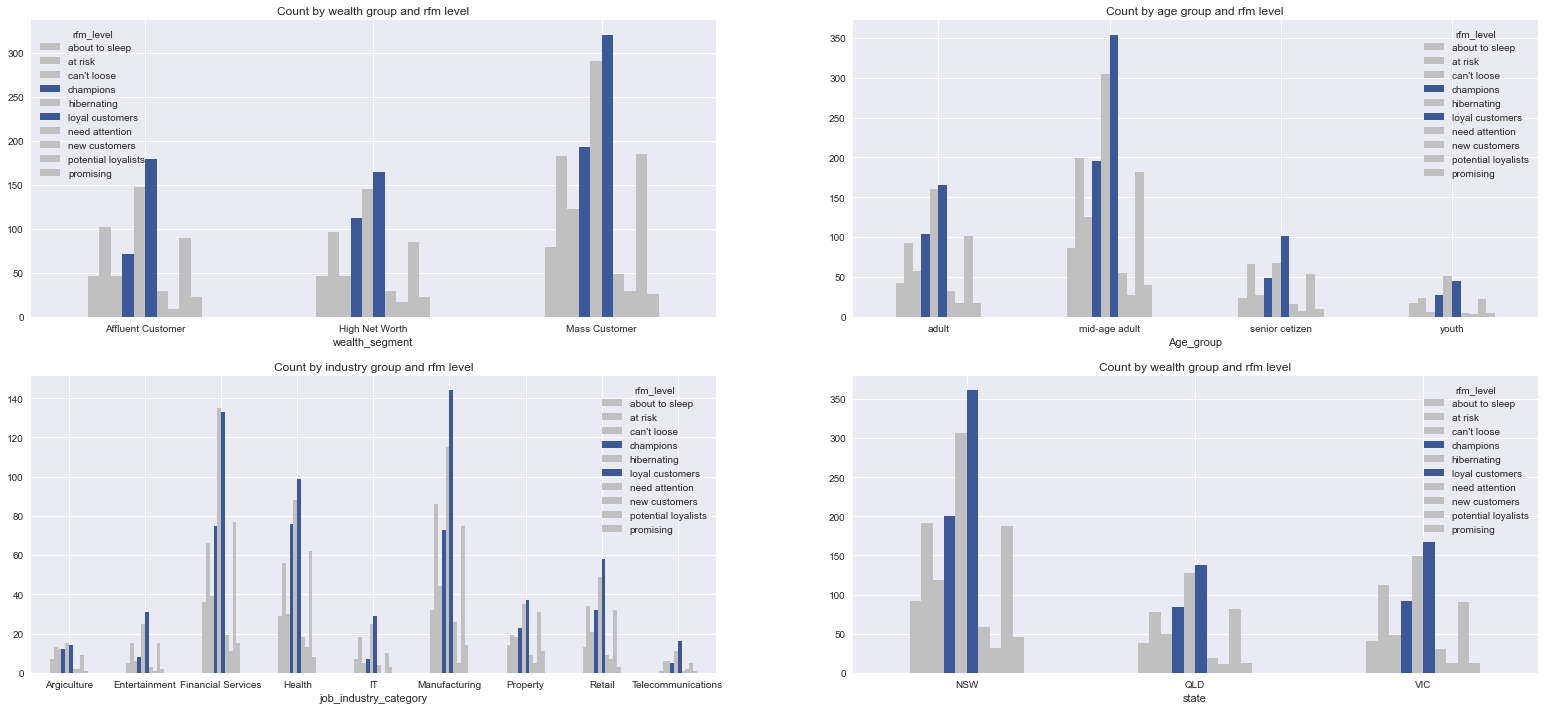

In [554]:
wealth_df = cdrfm_df.groupby(['wealth_segment', 'rfm_level'])['rfm_level'].count().unstack().fillna(0)
age_df = cdrfm_df.groupby(['Age_group', 'rfm_level'])['rfm_level'].count().unstack().fillna(0)
industry_df = cdrfm_df.groupby(['job_industry_category', 'rfm_level'])['rfm_level'].count().unstack().fillna(0)
location_df = cdrfm_df.groupby(['state', 'rfm_level'])['rfm_level'].count().unstack().fillna(0)

plt.style.use('seaborn')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (27,12))
colors = ['silver', 'silver', 'silver', '#3b5998','silver', '#3b5998', 'silver', 'silver', 'silver','silver', 'silver', 'silver']
wealth_df.plot(ax=axes[0,0], kind = "bar", rot= 0, color = colors, title = 'Count by wealth group and rfm level')
age_df.plot(ax=axes[0,1], kind = "bar", rot= 0, color = colors, title = 'Count by age group and rfm level')
industry_df.plot(ax=axes[1,0], kind = "bar", rot= 0, color = colors, title = 'Count by industry group and rfm level')
location_df.plot(ax=axes[1,1], kind = "bar", rot= 0, color = colors, title = 'Count by wealth group and rfm level')
plt.show()

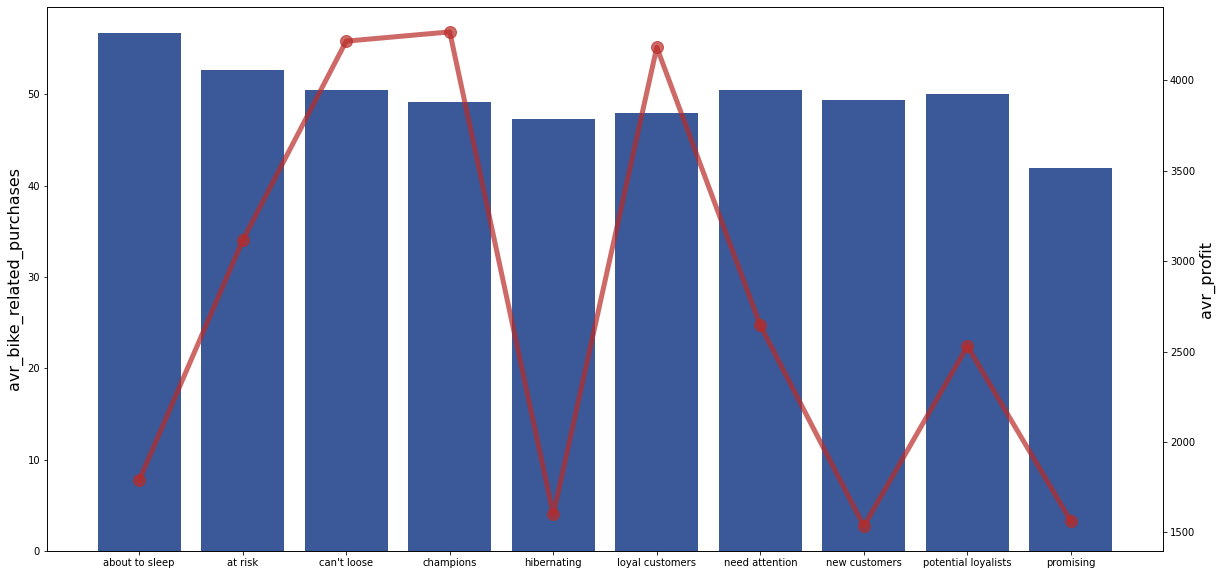

In [359]:
def bike_profit():
    plt.style.use('seaborn')
    # Data Prep
    bike_moneny = cdrfm_df.groupby('rfm_level').agg(
        past_3_years_bike_related_purchases = ('past_3_years_bike_related_purchases','mean'),
        monetary = ('monetary', 'mean')
    ).astype(float).round(2)
    # plot
    labels = bike_moneny.index
    bike = bike_moneny['past_3_years_bike_related_purchases']
    profit = bike_moneny['monetary']
    fig, axes = plt.subplots(figsize=(20,10))
    ax1 = plt.bar(labels, bike, color='#3b5998')
    plt.ylabel('avr_bike_related_purchases', fontsize=16)
    plt.twinx()
    ax2 = plt.plot(labels, profit, color='#b92b27',label='Sum', marker = 'o', markersize = 12, linewidth = 5, alpha = 0.7)
    plt.ylabel('avr_profit', fontsize=16)
bike_profit()

In [407]:
brand = cdrfm_df.groupby('rfm_level').agg(
    Giant = ('brand|Giant Bicycles','sum'),
    Norco = ('brand|Norco Bicycles','sum'),
    OHM = ('brand|OHM Cycles','sum'),
    Solex = ('brand|Solex','sum'),
    Trek = ('brand|Trek Bicycles','sum'),
    WeareA2B = ('brand|WeareA2B','sum')
).astype(int)
p_class = cdrfm_df.groupby('rfm_level').agg(
    high = ('product_class|high','sum'),
    low = ('product_class|low','sum'),
    medium = ('product_class|medium','sum'),
).astype(int)
p_line = cdrfm_df.groupby('rfm_level').agg(
    Standard = ('product_line|Standard','sum'),
    Touring = ('product_line|Touring','sum'),
    Mountain = ('product_line|Mountain','sum'),
    Road = ('product_line|Road','sum'),
).astype(int)
p_size = cdrfm_df.groupby('rfm_level').agg(
    large = ('product_size|large','sum'),
    medium = ('product_size|medium','sum'),
    small = ('product_size|small','sum'),
).astype(int)

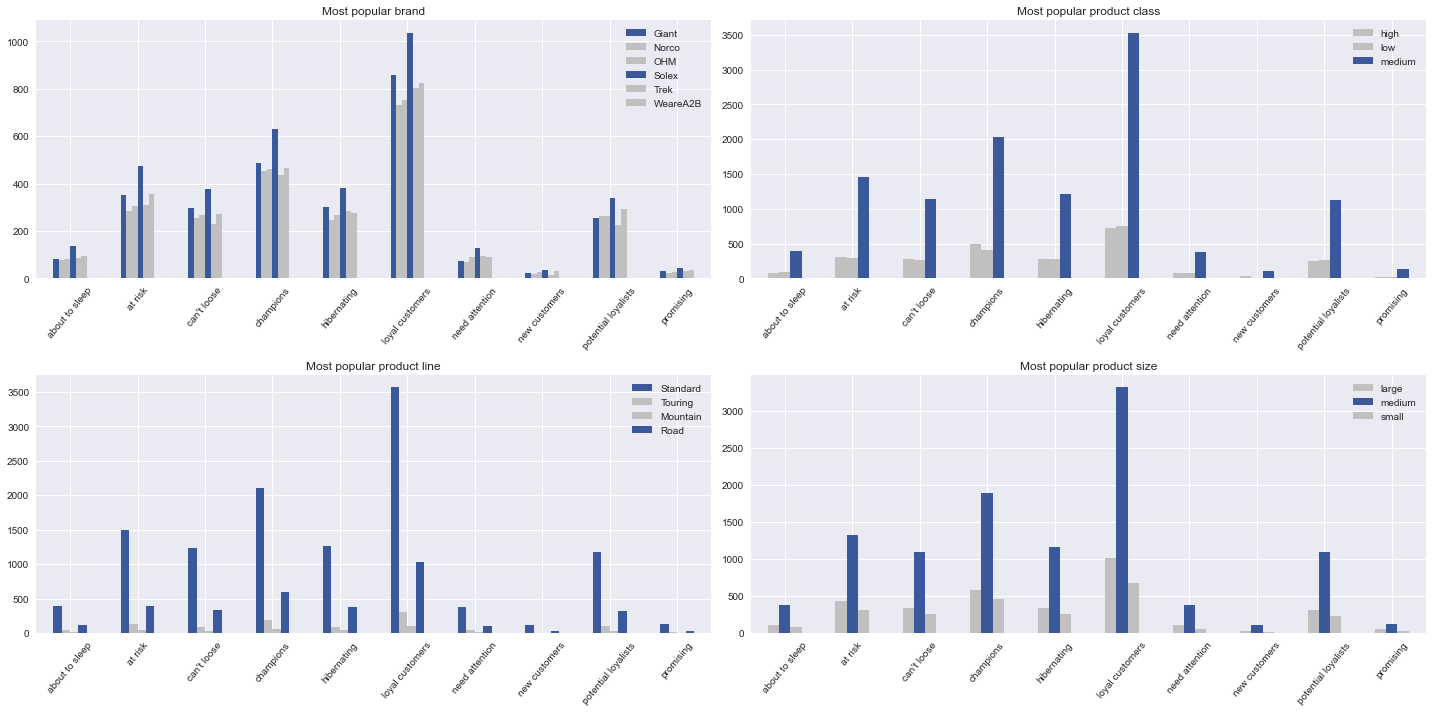

In [499]:
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (20,10))
ax1 = brand.plot(ax=axes[0,0], kind = "bar", rot= 50, title = 'Most popular brand', color = ['#3b5998','silver','silver','#3b5998','silver','silver'])
ax2 = p_class.plot(ax=axes[0,1], kind = "bar", rot= 50, title = 'Most popular product class',color = ['silver','silver','#3b5998'])
ax3 = p_line.plot(ax=axes[1,0], kind = "bar", rot= 50,  title = 'Most popular product line', color = ['#3b5998','silver','silver','#3b5998'])
ax4 = p_size.plot(ax=axes[1,1], kind = "bar", rot= 50, title = 'Most popular product size', color = ['silver', '#3b5998','silver'])

ax1.set_xlabel('')

ax2.set_xlabel('')

ax3.set_xlabel('')

ax4.set_xlabel('')

plt.tight_layout()
plt.show()

In [547]:
gender_car_df = cdrfm_df.groupby(['gender', 'owns_car'])['owns_car'].count().unstack().fillna(0)
gender_car_df = cdrfm_df.groupby('gender').agg(
    online = ('online_order|True','sum'),
    offline = ('online_order|False', 'sum')
).astype(int)


In [557]:
cdrfm_df.to_csv('cdrfm_df.csv', encoding = 'utf-8-sig')
cd_df.to_csv('cd_df.csv', encoding = 'utf-8-sig', index = False)
ncl_df.to_csv('ncl_df.csv', encoding = 'utf-8-sig', index = False)
t_df.to_csv('t_df.csv', encoding = 'utf-8-sig', index = False)
ca_df.to_csv('ca_df.csv', encoding = 'utf-8-sig', index = False)